# Clustering and Viz Experimentation

In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools

from classifier_utilities import *

### importing datasets

In [2]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

l8_image_paths = ['/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
               '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif'
                 ]

s1_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined/aligned-LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_SAR.tif'
]

dem_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff'
]

landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))
    
dem_datasets = []
for fp in dem_image_paths:
    dem_datasets.append(rasterio.open(fp))

In [3]:
# What is the raster's projection?
image_proj = landsat_datasets[0].crs # 4326
print('Image projection:')
print(image_proj)
print('---')
# What is the raster's projection?
label_proj = sentinel_datasets[0].crs
print('Labels projection:')
print(label_proj)
print('---')
# What is the raster's projection?
label_proj = label_dataset.crs
print('Labels projection:')
print(label_proj)

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
---
Labels projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PAR

### Class Dictionary and Confusion Matrix Function

In [4]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

## Scikit-learn ML Approaches

### Prep Data for training and validation

In [5]:
# get pixel locations
train_pixels = gen_balanced_pixel_locations(image_datasets=landsat_datasets[:1], train_count=50000, label_dataset=label_dataset)


train_to_val_ratio = 0.8
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# get training data from those pixel locations
batch_size = len(train_px)
sk_im_batch, sk_label_batch = pixel_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, train_px, batch_size)
print(sk_im_batch.shape, sk_label_batch.shape)

In [ ]:
batch_size = len(val_px)
sk_im_batch_val, sk_label_batch_val = pixel_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, val_px, batch_size)
print(sk_im_batch_val.shape, sk_label_batch_val.shape)

#### Merging Classes

In [18]:
y = np.argmax(sk_label_batch, axis=1)

# medium intensity and high intensity
y[y == 3] = 2

y[y == 9] = 11
y[y == 10] = 11
y[y == 13] = 11
y[y == 14] = 11 
y[y == 16] = 11

#y[y == 15] = 18

y[y == 22] = 23



#### Spectral Signatures

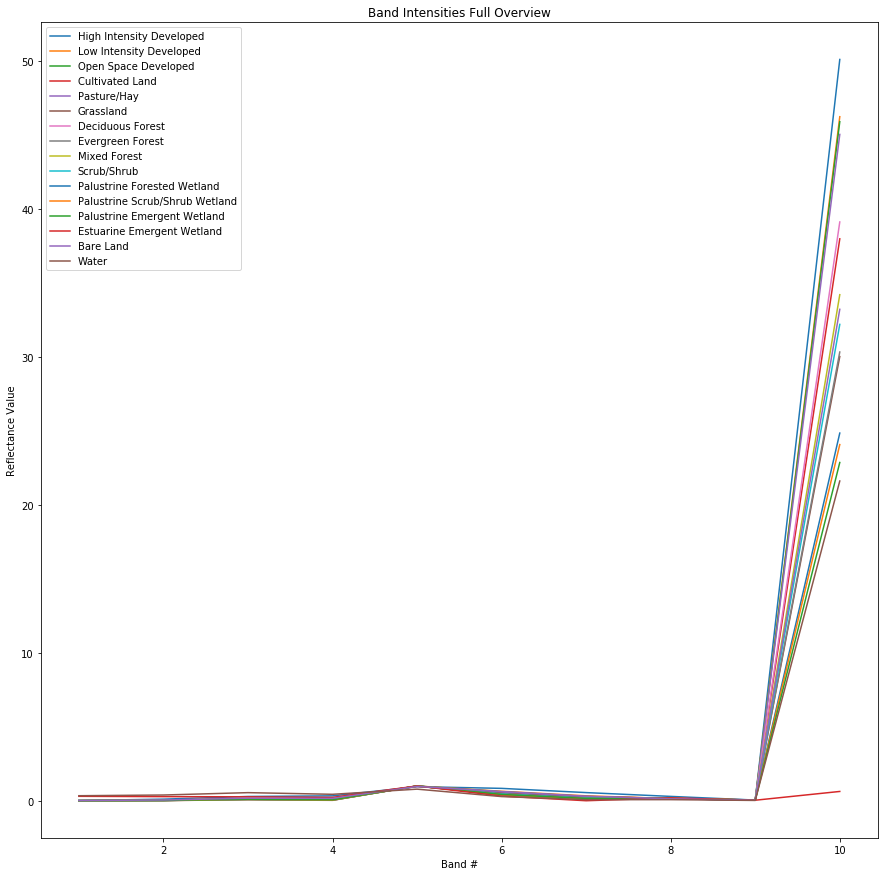

In [8]:
fig, ax = plt.subplots(1,1, figsize=[15,15])

# numbers 1-8
band_count = np.arange(1,11)

y = np.argmax(sk_label_batch, axis=1)
# adding NDVI and then concatenating it to the array
#X = np.concatenate((sk_im_batch, np.array([((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3]))]).T), axis=1)
X = sk_im_batch

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


In [23]:
np.argmax(sk_label_batch, axis=1)

array([13, 14, 14, 13, 14, 10, 13,  6,  6, 13, 13, 13, 14,  6,  6,  4, 10,
       12,  8,  6, 13, 13, 13, 11,  6, 10, 15,  6,  6, 14,  6, 11,  6, 15,
       14,  8, 14,  6, 20, 13, 10, 13, 13, 12, 13, 13,  2,  6, 13,  6])

In [24]:
unique, counts = np.unique(np.argmax(sk_label_batch, axis=1), return_counts=True)
dict(zip(unique, counts))

{2: 1, 4: 1, 6: 13, 8: 2, 10: 4, 11: 2, 12: 2, 13: 15, 14: 7, 15: 2, 20: 1}

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

spectral_sigs = []

y = np.argmax(sk_label_batch, axis=1)
# adding NDVI and then concatenating it to the array
X = np.concatenate((sk_im_batch, np.array([((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3]))]).T), axis=1)
classes = np.unique(y)

for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    spectral_sigs.append(band_intensity)
    ax.plot(band_count, band_intensity, label=class_names[class_type])



In [27]:
classes

array([ 2,  4,  6,  8, 10, 11, 12, 13, 14, 15, 20])

In [28]:
cosine_similarity(spectral_sigs, spectral_sigs).shape

(11, 11)

In [29]:
cos_sim = cosine_similarity(spectral_sigs, spectral_sigs)

In [30]:
cos_sim_top = np.argsort(-cos_sim)[:,:5]
cos_sim_top_score = np.sort(-cos_sim)[:,:5]

In [31]:
for i, top in enumerate(cos_sim_top):
    print('For ', class_names[classes[i]], 'with', dict(zip(unique, counts))[classes[i]], 'the most similar are:')
    for index, class_index in enumerate(top):
        class_id = classes[class_index]
        score = round(cos_sim_top_score[i][index], 3)
        print('\t', class_names[class_id], '-', class_id, '-', score)
    print('---')

For  High Intensity Developed with 1 the most similar are:
	 High Intensity Developed - 2 - -1.0
	 Low Intensity Developed - 4 - -0.946
	 Cultivated Land - 6 - -0.939
	 Grassland - 8 - -0.917
	 Scrub/Shrub - 12 - -0.907
---
For  Low Intensity Developed with 1 the most similar are:
	 Low Intensity Developed - 4 - -1.0
	 High Intensity Developed - 2 - -0.946
	 Cultivated Land - 6 - -0.786
	 Grassland - 8 - -0.746
	 Scrub/Shrub - 12 - -0.732
---
For  Cultivated Land with 13 the most similar are:
	 Cultivated Land - 6 - -1.0
	 Grassland - 8 - -0.996
	 Scrub/Shrub - 12 - -0.995
	 Mixed Forest - 11 - -0.99
	 Palustrine Emergent Wetland - 15 - -0.988
---
For  Grassland with 2 the most similar are:
	 Grassland - 8 - -1.0
	 Scrub/Shrub - 12 - -0.999
	 Cultivated Land - 6 - -0.996
	 Mixed Forest - 11 - -0.995
	 Palustrine Emergent Wetland - 15 - -0.993
---
For  Evergreen Forest with 4 the most similar are:
	 Evergreen Forest - 10 - -1.0
	 Palustrine Scrub/Shrub Wetland - 14 - -1.0
	 Bare Land - 

#### PCA and Clustering

In [11]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)
data = sk_im_batch

n_samples, n_features = sk_im_batch.shape
n_digits = len(np.unique(np.argmax(sk_label_batch, axis=1)))
labels = np.argmax(sk_label_batch, axis=1)

sample_size = 50

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

n_digits: 11, 	 n_samples 50, 	 n_features 9
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.05s	0	0.385	0.361	0.372	0.016	0.040	0.302
random   	0.02s	0	0.401	0.347	0.372	0.009	0.020	0.283


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


ValueError: n_components=11 must be between 0 and min(n_samples, n_features)=9 with svd_solver='full'

In [57]:
centroids.shape

(19, 2)

In [12]:
# next setup a colormap for our map
colors = dict((
(0, (245,245,245, 255)), # Background
(1, (0,0,0)), # Unclassified (Cloud, Shadow, etc)
(2, (255,0,0)), # High Intensity Developed
(3, (255, 110, 51)), # Medium Intensity Developed
(4, (255, 162, 51)), # Low Intensity Developed
(5, (255, 162, 51)), # Open Space Developed
(6, (162, 89, 0)), # Cultivated Land
(7, (229, 221, 50)), # Pasture/Hay
(8, (185, 251, 96)), # Grassland
(9, (83, 144, 0)), # Deciduous Forest
(10, (13, 118, 0  )), # Evergreen Forest
(11, (62, 178, 49)), # Mixed Forest
(12, (100, 241, 125)), # Scrub/Shrub
(13, (68, 160, 85)), # Palustrine Forested Wetland
(14, (118, 192, 131)), # Palustrine Scrub/Shrub Wetland
(15, (188, 0, 211)), # Palustrine Emergent Wetland
(16, (188, 0, 211)), # Estuarine Forested Wetland
(17, (0, 0, 0)), # Estuarine Scrub/Shrub Wetland
(18, (172, 0, 191)), # Estuarine Emergent Wetland
(19, (159, 251, 255)), # Unconsolidated Shore 
(20, (172, 177, 68)), # Bare Land
(21, (29, 0, 189)), # Water
(22, (29, 0, 189)), # Palustrine Aquatic Bed
(23, (91, 199, 169)), # Estuarine Aquatic Bed
(24, (159, 251, 255)), # Tundra
(25, (159, 251, 255)), # Snow/Ice
))

n = 25

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

In [13]:
fig = plt.figure(figsize=(16,10))
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=6,
            color='black', zorder=10)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=np.argmax(sk_label_batch, axis=1), cmap=cmap)
cb = plt.colorbar()
loc = np.arange(0,max(class_names),max(class_names)/float(len(class_names)))
cb.set_ticks(loc)
cb.set_ticklabels(class_names)

NameError: name 'centroids' is not defined

<Figure size 1152x720 with 0 Axes>

In [14]:
reduced_data.shape

NameError: name 'reduced_data' is not defined

In [30]:
np.argmax(sk_label_batch, axis=1).shape

(50000,)

In [62]:
sk_im_batch.shape

(50000, 8)

In [15]:
np.argmax(sk_label_batch, axis=1).shape

(50,)

In [16]:
np.array([((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3]))]).shape

(1, 50)

In [ ]:
np.concatenate((a, b.T), axis=1)

In [17]:
((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3])).shape

(50,)